<a href="https://colab.research.google.com/github/wgrgwrght/Simple-Diffusion/blob/main/SimpleDiffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Statements

In [27]:
# import statements
import matplotlib.pyplot as plt

import numpy as np

import torch, torchvision
from torch import nn
from torch.nn import functional as F

In [28]:
# use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'device {device}')

device cpu


# Create Data

In [29]:
small = np.random.normal(loc=25, scale=0.0, size=10000)
large = np.random.normal(loc=100, scale=0.0, size=15000)

large = [[torch.tensor((a-50)/90).float()] for a in large]
small = [[torch.tensor((a-50)/90).float()] for a in small]
dataset = torch.tensor(large + small)

train_input = dataset.to(device)

In [30]:
# df = [[a[0] for a in result.tolist()]]
# df.append([a[0] for a in result.tolist()])
# df.append([a[0] for a in result.tolist()])
# df = np.array(df)

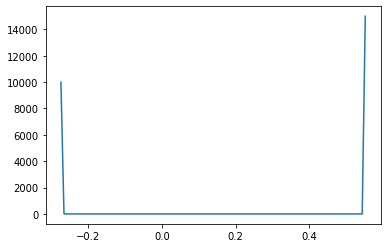

In [31]:
#show distribution
hist, bins = np.histogram(dataset, bins=100)
bin_centers = (bins[1:]+bins[:-1])*0.5
plt.plot(bin_centers, hist)
plt.show()

# Forward Process

In [32]:
# precompute values

T = 50
beta = torch.linspace(1e-4, 0.02, T, device = device)
alpha = 1 - beta
alpha_bar = alpha.log().cumsum(0).exp()
sigma = beta.sqrt()
sqrt_recip_alpha = torch.sqrt(1.0 / alpha)
sqrt_alpha_bar = torch.sqrt(alpha_bar)
sqrt_one_minus_alpha_bar = torch.sqrt(1. - alpha_bar)

In [33]:
""" 
Takes an image and a timestep as input and 

returns the noisy version of it
"""
def forward_diffusion_sample(x_0, t, device="cpu"):

    # define noise to add
    noise = torch.randn_like(x_0)
    
    # add noise to data
    mean = sqrt_alpha_bar[t].to(device) * x_0.to(device)
    variance = sqrt_one_minus_alpha_bar[t].to(device) * noise.to(device)
    
    return mean + variance, noise.to(device)

In [34]:
"""
Image as input

Returns specified number of images showing forward noise diffusion
"""

def show_noise(data, min_num_images):
    # initialise return lists
    timesteps = []
    labels = []
    
    # choose timesteps to record
    stepsize = int(T/(min_num_images-1))
    steps = list(range(0, T, stepsize))
    steps.append(T-1)
    
    for t in steps:
        
        # get noisy version of data and append to list
        data_t, noise = forward_diffusion_sample(data, t, device=device)
        
        #append to list in list format for plotting
        timesteps.append([record[0] for record in data_t.tolist()])
        labels.append(t)
        
    return timesteps, labels


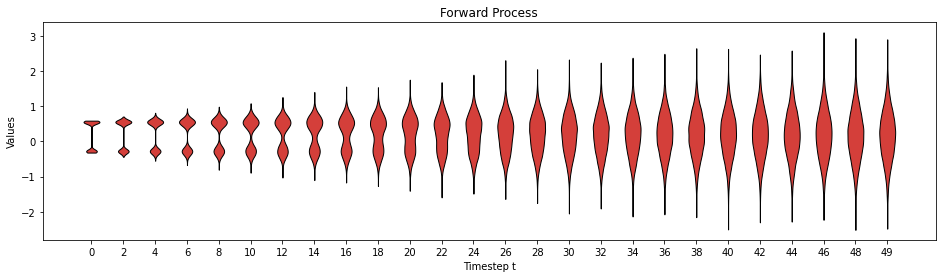

In [35]:
# plot forward process

ts, ls = show_noise(dataset, 20)

fig, ax = plt.subplots(nrows=1, figsize=(16, 4), sharey=True)

parts = ax.violinplot(ts, showmeans=False, showmedians=False, showextrema=False)

for pc in parts['bodies']:
    pc.set_facecolor('#D43F3A')
    pc.set_edgecolor('black')
    pc.set_alpha(1)

ax.set_xticks(np.arange(1, len(ls) + 1))
ax.set_xticklabels(ls)
ax.set_title('Forward Process')
ax.set_ylabel('Values')
ax.set_xlabel('Timestep t')

plt.show()

# Model

In [36]:
# Gets a pair (x, t) and appends t (scalar or 1d tensor) to x as an
# additional dimension / channel

class TimeAppender(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, u):
        x, t = u
        if not torch.is_tensor(t):
            t = x.new_full((x.size(0),), t)
        t = t.view((-1,) + (1,) * (x.dim() - 1)).expand_as(x[:,:1])
        return torch.cat((x, t), 1)

In [37]:
# Define Model

nh = 256

model = nn.Sequential(
    TimeAppender(),
    nn.Linear(train_input.size(1) + 1, nh),
    nn.ReLU(),
    nn.Linear(nh, nh),
    nn.ReLU(),
    nn.Linear(nh, nh),
    nn.ReLU(),
    nn.Linear(nh, train_input.size(1)),
)

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

model.to(device)

print(f'nb_parameters {sum([ p.numel() for p in model.parameters() ])}')

model.eval()

nb_parameters 132609


Sequential(
  (0): TimeAppender()
  (1): Linear(in_features=2, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=256, bias=True)
  (6): ReLU()
  (7): Linear(in_features=256, out_features=1, bias=True)
)

#Train Model

In [38]:
epochs = 100
batch_size = 1024

for k in range(epochs):

    epoch_loss = 0

    for x0 in train_input.split(batch_size):
        
        # pick random t
        t = torch.randint(T, (x0.size(0),) + (1,) * (x0.dim() - 1), device = x0.device)
        
        # adds random noise for timestep t
        noise = torch.randn_like(x0)
        xt = torch.sqrt(alpha_bar[t]) * x0 + torch.sqrt(1 - alpha_bar[t]) * noise
        
        # model predicts the noise
        noise_pred = model((xt, t / (T - 1) - 0.5))
        
        # loss function 
        loss = F.mse_loss(noise, noise_pred)
        epoch_loss += loss.item() * x0.size(0)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'{k} {epoch_loss / train_input.size(0)}')


0 0.9146535764694214
1 0.7431701488494873
2 0.6979349848937988
3 0.6228118163871765
4 0.600338434009552
5 0.58219852809906
6 0.5746948579978943
7 0.5640154067802429
8 0.5448347547340393
9 0.5401199656867981
10 0.5288143999099731
11 0.5163449663162232
12 0.5083958117485047
13 0.512059533252716
14 0.5086497318267822
15 0.4919178975296021
16 0.4892034494972229
17 0.47684589422225954
18 0.4808894599723816
19 0.4718372498512268
20 0.4705857467842102
21 0.46726448531150816
22 0.4512941763305664
23 0.44845142976760866
24 0.4479238885784149
25 0.4503017793178558
26 0.4476387467956543
27 0.42739969232559205
28 0.4271388501739502
29 0.4196613201522827
30 0.41883441301345825
31 0.41098226685523986
32 0.4185211359024048
33 0.4015235038566589
34 0.4050800587463379
35 0.3958473725128174
36 0.409012300491333
37 0.40580914905548093
38 0.39224654002189635
39 0.3826201036930084
40 0.3832600157928467
41 0.39064737827301027
42 0.3906157836055756
43 0.3708062165737152
44 0.37791619092941287
45 0.3711410401

# Generator


In [39]:
# function to generate a sample from noise

def generate(size, model, min_num_image):

    with torch.no_grad():
        
        ts = []
        ls = []
        
        # start with noise at x_T
        x_T = torch.randn(size, device = device)

        # go through all timesteps t back to x_0
        for t in range(T-1, -1, -1):
            
            # model noise prediction
            output = model((x_T, t / (T - 1) - 0.5))
            
            # formula to get timestep x_(t-1)
            z = torch.zeros_like(x_T) if t == 0 else torch.randn_like(x_T)
            x_T = 1/torch.sqrt(alpha[t]) \
                * (x_T - (1-alpha[t]) / torch.sqrt(1-alpha_bar[t]) * output) \
                + sigma[t] * z
            
            # add first timestep
            if t == (T-1):
                ts.append([a[0] for a in x_T.tolist()])
                ls.append(T-1)
            
            # add to list of timesteps for plotting
            if t % int(T/(min_num_image-1)) == 0:
                ts.append([a[0] for a in x_T.tolist()])
                ls.append(t)

        return x_T, ts, ls

# Reverse Process

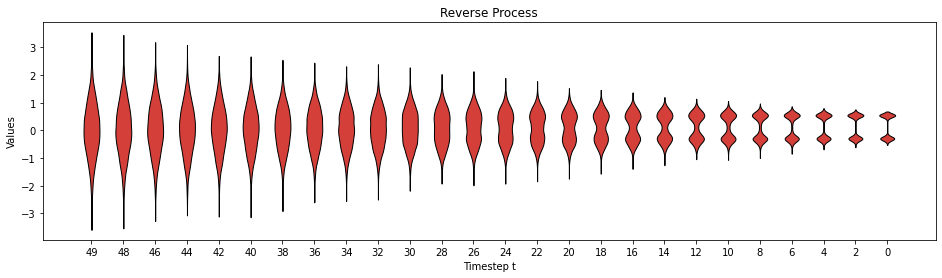

In [40]:
# plot reverse process

x_0, ts, ls = generate((10000, 1), model, 20)

fig, ax = plt.subplots(nrows=1, figsize=(16, 4), sharey=True)

parts = ax.violinplot(ts, showmeans=False, showmedians=False, showextrema=False)

for pc in parts['bodies']:
    pc.set_facecolor('#D43F3A')
    pc.set_edgecolor('black')
    pc.set_alpha(1)

ax.set_xticks(np.arange(1, len(ls) + 1))
ax.set_xticklabels(ls)
ax.set_title('Reverse Process')
ax.set_ylabel('Values')
ax.set_xlabel('Timestep t')

plt.show()

# Acknowledgements
https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/annotated_diffusion.ipynb#scrollTo=a30368b2

Francois Fleuret https://twitter.com/francoisfleuret/status/1558733449481027585?t=pn9I7NopfXFu2pkQAdWEuA&s=19